# **Module 2 of 3: Transfer Learning, Cross-Validation & Evaluation** - *Train a binary image classifier on your “potholes” vs. “road_without_potholes” dataset using MobileNetV2, stratified k-fold splits, and basic metrics plotting.*
---

# **Introduction** <br>
In Module 2, we move from data preparation to building and validating a real machine learning model. You’ll take the labeled “road_with_potholes” and “road_without_potholes” images you assembled in Module 1 and:

- Leverage Transfer Learning: Adapt a pretrained MobileNetV2 backbone—already rich in visual features from ImageNet—to our binary classification task with just a few added layers.

- Implement Stratified Cross-Validation: Split your dataset into multiple train/validation folds while preserving the balance between positive and negative classes.

- Train, Evaluate & Visualize: For each fold, you’ll train the model, track metrics, and then aggregate results across folds to measure overall accuracy and loss. Finally, you’ll plot training curves to diagnose under- or overfitting.

- By the end of this module, you will understand how to efficiently reuse pretrained networks, set up robust validation pipelines, and interpret training dynamics—key skills for any applied machine learning project.

Inspired by the Analytics Vidhya tutorial, our workflow covers the following steps: <br>

Vidhya tutorial link: https://medium.com/analytics-vidhya/how-to-train-a-neural-network-classifier-on-imagenet-using-tensorflow-2-ede0ea3a35ff

<br>

# 2. Model Building with Transfer Learning

###2.0 Setup & Imports (please run the following code cells)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install numpy pandas matplotlib
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow-addons
!pip install duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.9 MB/s eta 0:00:00


In [5]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow.keras.applications.mobilenet_v2 as mobilenet_v2
from google.colab import drive

In [6]:
import os
import sys

file_path = '/content/drive/MyDrive/ra/ml_utils.py'
file_dir = os.path.dirname(file_path)  # Get the directory containing ml_utils.py

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
    # Add the directory to Python's search path
    sys.path.append(file_dir)
    import ml_utils as mu
else:
    print(f"The file '{file_path}' does not exist. Please check the path and file name.")

The file '/content/drive/MyDrive/ra/ml_utils.py' exists.


In [7]:
BASE_DATA_DIR = "drive/MyDrive/ra/data"
RAW_IMAGE_DIR = os.path.join(BASE_DATA_DIR, "raw_images")

In [9]:
# TODO: Set TARGET to the object you want to detect.
#       e.g. TARGET = "potholes"         → folders “potholes” & “road_without_potholes”
#            TARGET = "zebra_crossing"   → folders “road_zebra_crossing” & “road_without_zebra_crossing”
# pos_pattern and neg_pattern are built from TARGET;
# make sure exactly one folder matches each before moving on.
TARGET = "potholes"

pos_pattern = f"{TARGET}"
neg_pattern = f"road_without_{TARGET}"

all_folders = os.listdir(RAW_IMAGE_DIR)
pos_folders = [f for f in all_folders if f == pos_pattern]
neg_folders = [f for f in all_folders if f == neg_pattern]

if len(pos_folders) != 1 or len(neg_folders) != 1:
    raise ValueError(
        f"Expect one pos folder matching '{pos_pattern}' and one neg matching '{neg_pattern}'.\n"
        f"Found pos: {pos_folders}, neg: {neg_folders}"
    )

class_names = pos_folders + neg_folders
print("Classes found:", class_names)

file_paths, labels = [], []
for cls_name in class_names:
    cls_folder = os.path.join(RAW_IMAGE_DIR, cls_name)
    label = 1 if cls_name in pos_folders else 0
    for fname in os.listdir(cls_folder):
        file_paths.append(os.path.join(cls_folder, fname))
        labels.append(label)

file_paths = np.array(file_paths)
labels     = np.array(labels)

print(f"Total {TARGET} images:", len(file_paths),
      "| positives:", int(labels.sum()), "negatives:", int(len(labels)-labels.sum()))

Classes found: ['potholes', 'road_without_potholes']
Total potholes images: 408 | positives: 215 negatives: 193


## 2.1 Building the Model (Transfer Learning)

In this section, we’ll dive into the rationale and mechanics of using transfer learning with MobileNetV2 for our binary image‐classification task. You’ll see why we leverage a pretrained backbone, how we “freeze” it, and what the added classification head does—complete with pointers to official guides and practical examples. <br>

In [10]:
# Define a Function to Build the Model
def build_model():
    """
    Builds and compiles a binary classification model using MobileNetV2 as the base.
    """
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False  # Freeze the pre-trained layers

    # On top of the frozen base, we stack:
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),      # To collapse spatial dimensions into a single feature vector
                                              # per image, reducing overfitting risk and parameter count
        layers.Dense(128, activation="relu"), # Layer to learn task‐specific combinations of features.
        layers.Dropout(0.5),                  # For further regularization.
        layers.Dense(1, activation="sigmoid") # Output probability for binary classification
    ])
    # For binary classification, we use the sigmoid activation on the final neuron and the binary_crossentropy loss.
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

**What Is Transfer Learning?** <br>
Transfer learning means taking a model pretrained on a large, generic dataset (like ImageNet) and reusing its learned feature extractors for a new task—here, distinguishing “potholes” vs. “road_without_potholes.” This lets us avoid training a deep network from scratch, saving time and data requirements. <br>
 <br>
Reference: https://www.tensorflow.org/tutorials/images/transfer_learning


**Why MobileNetV2?** <br>
MobileNetV2 is a lightweight CNN (Convolutional Neural Network) architecture specifically designed for mobile and embedded vision applications, offering a strong balance of model size and accuracy through its efficient use of separable convolutions and inverted residual blocks. MobileNetV2 comes bundled in tf.keras.applications with pretrained ImageNet weights, so you can instantly use its efficient, lightweight feature-extractor layers and just add a small classification head—letting you train quickly on modest data and hardware without building or tuning a full network from scratch <br>
<br>
Reference: https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2


## 2.2  Cross-Validation with StratifiedShuffleSplit

**Why Use Cross-Validation?** <br>
Cross-validation is a fundamental technique in machine learning that evaluates how well a model will generalize to unseen data by repeatedly partitioning the dataset into training and validation subsets. It helps prevent overfitting—where a model performs excellently on its training data but poorly in real-world scenarios—by ensuring that every data point gets a chance in the validation set.

**What Is a “Fold”?** <br>
A fold is simply one of the 𝑘 equally (or nearly equally) sized subsets that you split your dataset into
Scikit-learn. In 5-fold cross-validation, for example, you divide your trainning data into five parts (folds) of roughly the same size.

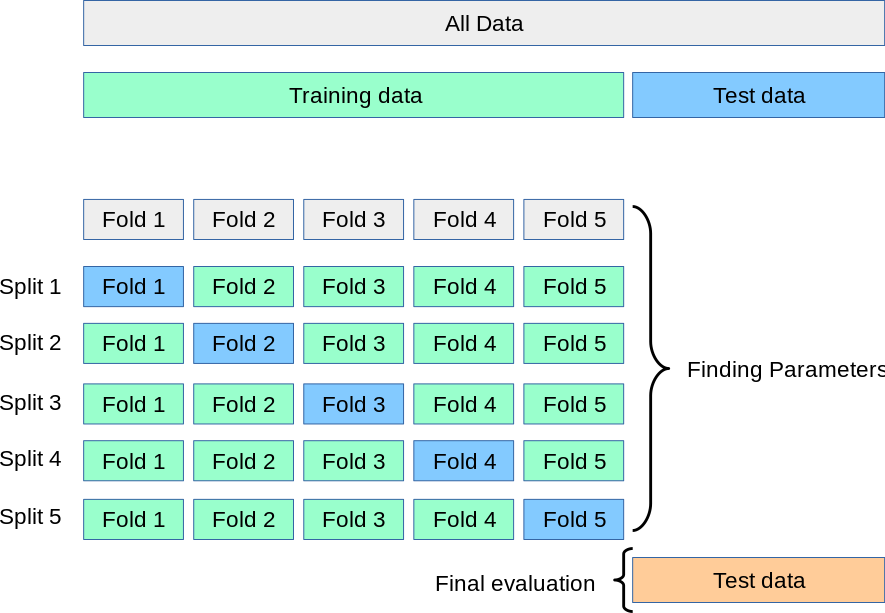

How K-Fold Cross-Validation Works:
1. Partition into 𝑘 folds
  - Shuffle your full dataset and split it into 𝑘 groups.

2. Iterate over folds

  - For each iteration 𝑖 (from 1 to 𝑘):

    - Training data = all folds except fold 𝑖.

    - Test data (validation data) = fold 𝑖.

    - Train the model on the training set and evaluate on the validation data.

3. Aggregate results

  - Collect the metric (e.g., accuracy) from each fold, then compute the mean and standard deviation to assess overall performance and variability.

- Example (3-fold):
  - Fold 1 as validation, train on Folds 2+3

  - Fold 2 as validation, train on Folds 1+3

  - Fold 3 as validation, train on Folds 1+2

Because each fold gets to serve as the “test” set exactly once, every sample is used for validation exactly once and for training 𝑘−1 times<br>
<br>
References:<br>
https://machinelearningmastery.com/k-fold-cross-validation <br>
https://scikit-learn.org/stable/_images/grid_search_cross_validation.png<br>

**What Is Stratified Cross-Validation?** <br>
In Stratified K-Fold, each fold preserves the same class proportions as the original dataset (e.g., if 30% of images have potholes, each fold’s validation set will also be ~30% potholes). This prevents folds from being skewed by chance, which is critical when classes are imbalanced



In [11]:
# Set Up StratifiedShuffleSplit for Cross Validation

# Splits the data into several k=5 folds (5 splits)

n_splits = 5
test_size = 0.2  # 80% training, 20% cross validation for each split
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

print("Total images for cross validation:", len(file_paths))

# Cross Validation Loop - Train and Evaluate the Model for Each Fold
fold = 1
fold_accs = []
fold_losses = []

for train_idx, val_idx in sss.split(file_paths, labels):
    print(f"\n===== Fold {fold} =====")
    # Split file paths and labels into training and validation sets for this fold
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create tf.data.Datasets using your pre-defined create_dataset function
    train_ds = mu.create_dataset(train_paths, train_labels)
    val_ds = mu.create_dataset(val_paths, val_labels)

    # Build a fresh model for this fold
    model = build_model()
    model.summary()

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=10) #defaut epochs = 10

    # Evaluate on the validation set
    loss, acc = model.evaluate(val_ds)
    print(f"Fold {fold} - Validation Accuracy: {acc:.2f}, Loss: {loss:.4f}")
    fold_accs.append(acc)
    fold_losses.append(loss)

    fold += 1

# Calculate and print average performance metrics across all folds
avg_acc = np.mean(fold_accs)
avg_loss = np.mean(fold_losses)
print(f"\nAverage Validation Accuracy over {n_splits} folds: {avg_acc:.2f}")
print(f"Average Validation Loss over {n_splits} folds: {avg_loss:.4f}")

Total images for cross validation: 408

===== Fold 1 =====
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.7272 - loss: 0.5676 - val_accuracy: 0.9634 - val_loss: 0.0972
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.9425 - loss: 0.1239 - val_accuracy: 0.9634 - val_loss: 0.1130
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9565 - loss: 0.0711 - val_accuracy: 0.9878 - val_loss: 0.0332
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9992 - loss: 0.0218 - val_accuracy: 0.9878 - val_loss: 0.0388
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.9878 - val_loss: 0.0251
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9966 - loss: 0.0268 - val_accuracy: 0.9878 - val_loss: 0.0293
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.9878 - val_loss: 0.0220
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9908 - loss: 0.0184 - val_accuracy: 0.9878 - val_loss:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6236 - loss: 0.8265 - val_accuracy: 0.9146 - val_loss: 0.1491
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9550 - loss: 0.1026 - val_accuracy: 0.9512 - val_loss: 0.0859
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9663 - loss: 0.0777 - val_accuracy: 0.9634 - val_loss: 0.0776
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9821 - loss: 0.0467 - val_accuracy: 0.9634 - val_loss: 0.0642
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9959 - loss: 0.0223 - val_accuracy: 0.9512 - val_loss: 0.0753
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9986 - loss: 0.0132 - val_accuracy: 0.9634 - val_loss: 0.0702
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9958 - loss: 0.0101 - val_accuracy: 0.9634 - val_loss: 0.0582
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.9634 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7305 - loss: 0.5514 - val_accuracy: 0.9268 - val_loss: 0.2016
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9501 - loss: 0.1181 - val_accuracy: 0.9756 - val_loss: 0.0831
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9917 - loss: 0.0412 - val_accuracy: 0.9634 - val_loss: 0.0653
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 0.9878 - val_loss: 0.0555
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9951 - loss: 0.0184 - val_accuracy: 0.9756 - val_loss: 0.0541
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 0.9878 - val_loss: 0.0490
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9878 - val_loss: 0.0515
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9878 - val_loss:

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6533 - loss: 0.6889 - val_accuracy: 0.9268 - val_loss: 0.1636
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9511 - loss: 0.1166 - val_accuracy: 0.9512 - val_loss: 0.0968
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9645 - loss: 0.0664 - val_accuracy: 0.9756 - val_loss: 0.0718
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9738 - loss: 0.0518 - val_accuracy: 0.9756 - val_loss: 0.0599
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9978 - loss: 0.0248 - val_accuracy: 0.9756 - val_loss: 0.0582
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9973 - loss: 0.0251 - val_accuracy: 0.9756 - val_loss: 0.0548
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.9878 - val_loss: 0.0539
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9989 - loss: 0.0092 - val_accuracy: 0.9756 - val_loss:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7964 - loss: 0.4544 - val_accuracy: 0.9390 - val_loss: 0.1242
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9673 - loss: 0.0838 - val_accuracy: 0.9512 - val_loss: 0.1120
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9847 - loss: 0.0479 - val_accuracy: 0.9512 - val_loss: 0.0899
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9823 - loss: 0.0396 - val_accuracy: 0.9512 - val_loss: 0.1215
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.9634 - val_loss: 0.0818
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.9512 - val_loss: 0.0932
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9512 - val_loss: 0.0957
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9512 - val_loss:

## 2.3 Evaluating the Model: Accuracy and Loss

In this step, we focus on understanding the basic performance of our model using two key metrics: accuracy and loss. The training process produces two curves—one for accuracy and one for loss—plotted over each epoch. The accuracy curve tells us how often the model’s predictions match the true labels, while the loss curve shows the error magnitude. When both curves level off, it indicates that the model has largely “converged,” meaning additional training may not lead to significant improvements.

In [12]:
# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 846ms/step - accuracy: 0.9483 - loss: 0.2029
Test Accuracy: 0.95
Test Loss: 0.1840


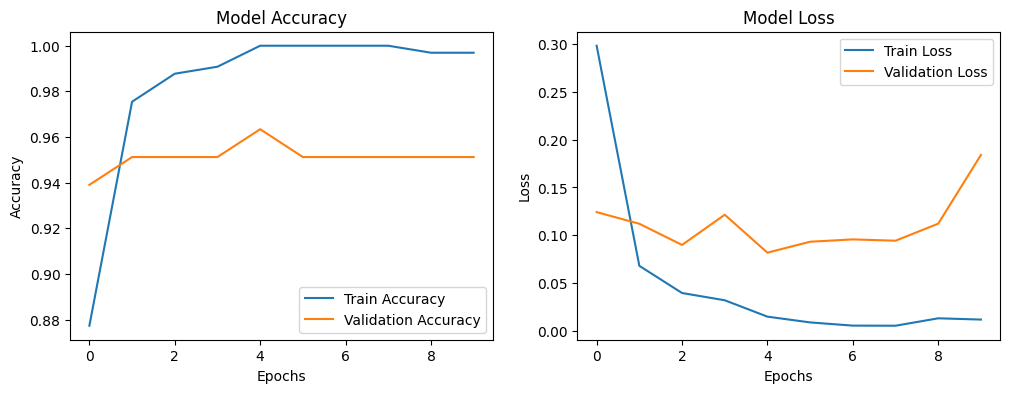

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation accuracy and loss.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_training_history(history)

**What to Look For:**<br>
<br>
**Underfitting:** <br>
*  Symptom: Both training and validation accuracy stay low (e.g. < 80%) and loss remains high or plateaus early.<br>

*  Interpretation: The model is too simple or hasn’t learned enough from the data. You might need more capacity (e.g. unfreeze some backbone layers), more training epochs, or better features.<br>
<br>

**Good Fit:**<br>

*   Symptom: Training and validation accuracy both rise and then level off close together, with validation loss roughly tracking training loss.

*  Interpretation: The model is learning the underlying patterns without memorizing noise—this is the “sweet spot.”<br>
<br>

**Overfitting:**<br>

*  Symptom: Training accuracy continues to improve toward 100% while validation accuracy stagnates or declines. Validation loss stops decreasing or even climbs while training loss keeps falling.

*  Interpretation: The model is memorizing training examples rather than generalizing. Common remedies include adding dropout or data augmentation, reducing model capacity, or using early stopping.

**Quick Over/Underfitting Check:** <br>
- **If** (train_acc – val_acc) > 0.05  → possible **overfitting**
- **If** (train_acc and val_acc) both < 0.80 → possible **underfitting**

Once you are comfortable with these basic metrics, we will introduce more detailed evaluation measures like the F1 Score, which balances precision and recall. This gradual progression—from simple accuracy and loss visualization to advanced metrics—helps build a comprehensive understanding of model performance.

## 2.4 Evaluating the Model: F1 Score

Beyond simple accuracy, we also calculate evaluation metrics like the F1 Score. In our code, after training the model on the test set (or the validation splits during cross-validation), we use scikit-learn’s f1_score function to compare the model’s predictions (converted to binary labels with a threshold of 0.5) with the ground truth.

In [17]:
from sklearn.metrics import f1_score

val_preds = []
val_trues = []
for images, labs in val_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).squeeze()
    val_preds.extend(preds.tolist())
    val_trues.extend(labs.numpy().tolist())

f1 = f1_score(val_trues, val_preds)
print("F1 Score for last fold's val set:", f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
F1 Score for last fold's val set: 0.9555555555555556


### 2.5 Model Saving

In [18]:
model.save("drive/MyDrive/ra/trained_models/potholes_classifier.h5")
print("model saved: potholes_classifier.h5")

model saved: potholes_classifier.h5
